In [2]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display
import numpy as np
import PIL.Image
import time
import functools
import time
import imageio

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

In [3]:
style_path = 'CompositionVII_style.jpg'
content_path = 'MBS_content.jpg'
feature_maps = True
create_gif = True
plot_loss = True
gif_fps = 2

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_layers = ['block5_conv2']

style_weight = 0.5e-2
content_weight = 1e4
total_variation_weight = 30
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
def load_img(path):
  max_dim = 512
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  scale = max_dim / max(shape)

  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  return img[tf.newaxis, :]

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [7]:
def display_images(content_path, style_path):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    ax = plt.subplot(1, 2, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    imshow(content_image, 'Content Image')

    ax = plt.subplot(1, 2, 2)
    ax.set_xticks([])
    ax.set_yticks([])
    imshow(style_image, 'Style Image')

    return content_image, style_image

In [8]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [9]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [10]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, image):
    "Expects float input in [0,1]"
    image = image*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(image)
    outputs = self.vgg(preprocessed_input)
    self.outputs = outputs

    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [22]:
def display_feature_maps(layer_names, square = 4):
  path = 'Feature Maps'
  if not os.path.exists(path):
    os.makedirs(path)
  
  model = vgg_layers(layer_names)
  feature_maps = model(style_image)

  if len(feature_maps) == 1:
    feature_maps = [feature_maps]

  for i,feature_map in enumerate(feature_maps):
    j = 1
    for _ in range(square):
      for _ in range(square):
        ax = plt.subplot(square, square, j)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        plt.imshow(feature_map[0,:, :, j-1])
        j += 1

    plt.savefig(os.path.join(path,'Sample feature map of' + layer_names[i] + '.jpg'))
    print()
    print('Sample feature map of', layer_names[i], 'of shape', feature_map.shape)
    print()
    plt.subplots_adjust(hspace=-0.6, wspace=0.1)
    plt.show()

In [12]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [13]:
def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    num_style_layers = len(style_outputs)
    num_content_layers = len(content_outputs)

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [14]:
@tf.function()
def train_step(image, extractor, style_targets, content_targets, opt):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_targets, content_targets)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

In [15]:
def train_model(style_image, content_image, style_layers, content_layers, opt, epochs = 10, steps_per_epoch = 100):
  extractor = StyleContentModel(style_layers, content_layers)
  # results = extractor(content_image)
  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']

  image = tf.Variable(content_image)

  start = time.time()
  losses = []
  images = []
  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      loss = train_step(image, extractor, style_targets, content_targets, opt)
      losses.append(loss)
      print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    images.append(image[0])
    print()
    print("Train step: {}/{}".format(step, epochs * steps_per_epoch))

  end = time.time()
  print("Total time: {:.1f}".format(end-start))
  print()

  return losses, images

In [16]:
def gif(images, content_path, gif_fps):

    print('Creating Gif...')

    path = 'Epoch Images'
    if not os.path.exists(path):
      os.makedirs(path)

    file_names = []
    gif_images = []
    for ix, image in enumerate(images):
      file_name = 'epoch ' + str(ix+1) + '.jpg'
      tf.keras.utils.save_img(os.path.join(path, file_name), image)
      file_names.append(file_name)

    tf.keras.utils.save_img(os.path.join(path,'epoch 0.jpg'), load_img(content_path)[0])
    gif_images.append(imageio.imread(os.path.join(path,'epoch 0.jpg')))

    for file_name in file_names:
      gif_images.append(imageio.imread(os.path.join(path,file_name)))
      imageio.mimsave('NST.gif', gif_images, fps = gif_fps)
    print('Gif created.')
    print()

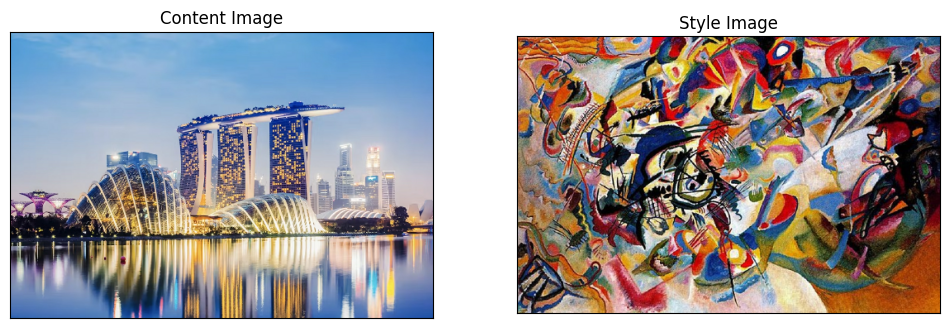

In [18]:
content_image, style_image = display_images(content_path, style_path)


Sample feature map of block5_conv2 of shape (1, 21, 32, 512)



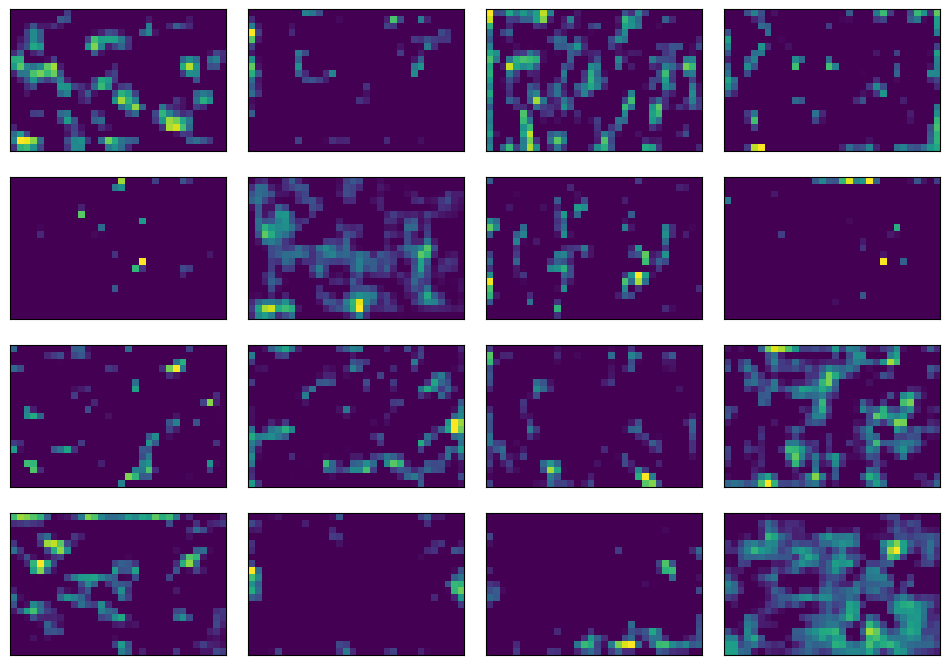


Sample feature map of block1_conv1 of shape (1, 336, 512, 64)



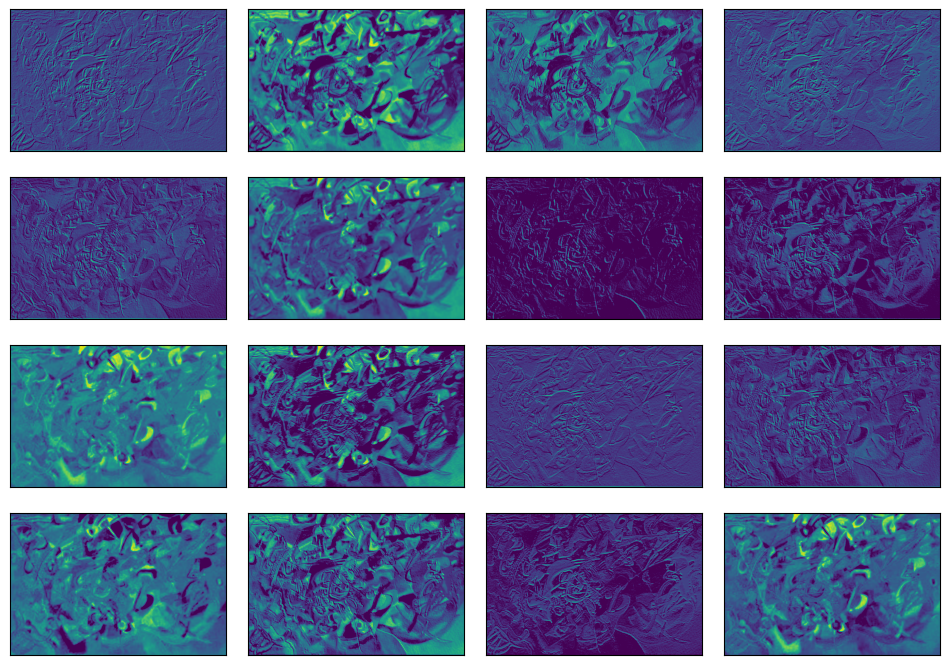


Sample feature map of block2_conv1 of shape (1, 168, 256, 128)



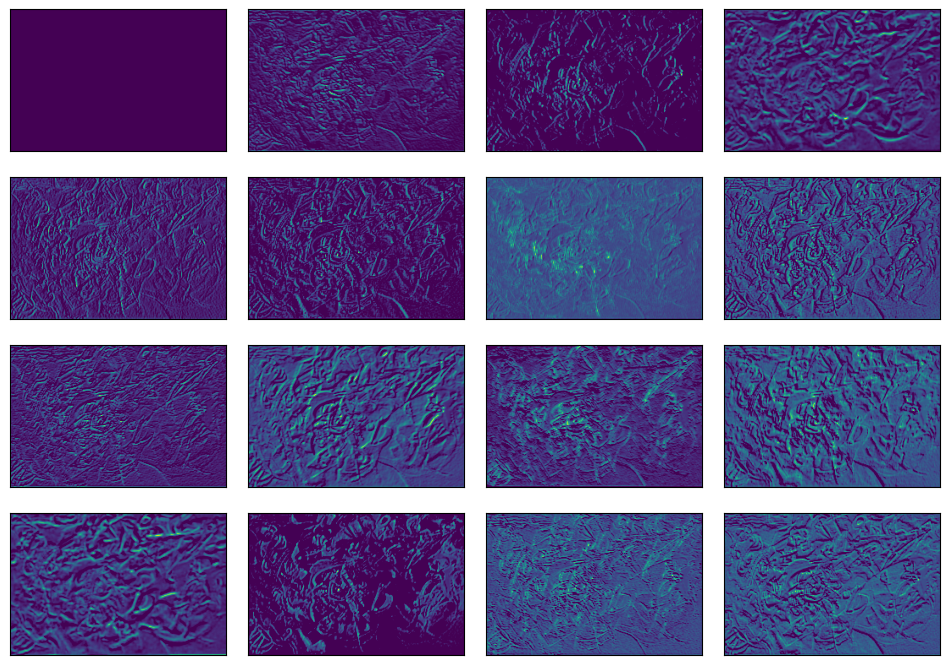


Sample feature map of block3_conv1 of shape (1, 84, 128, 256)



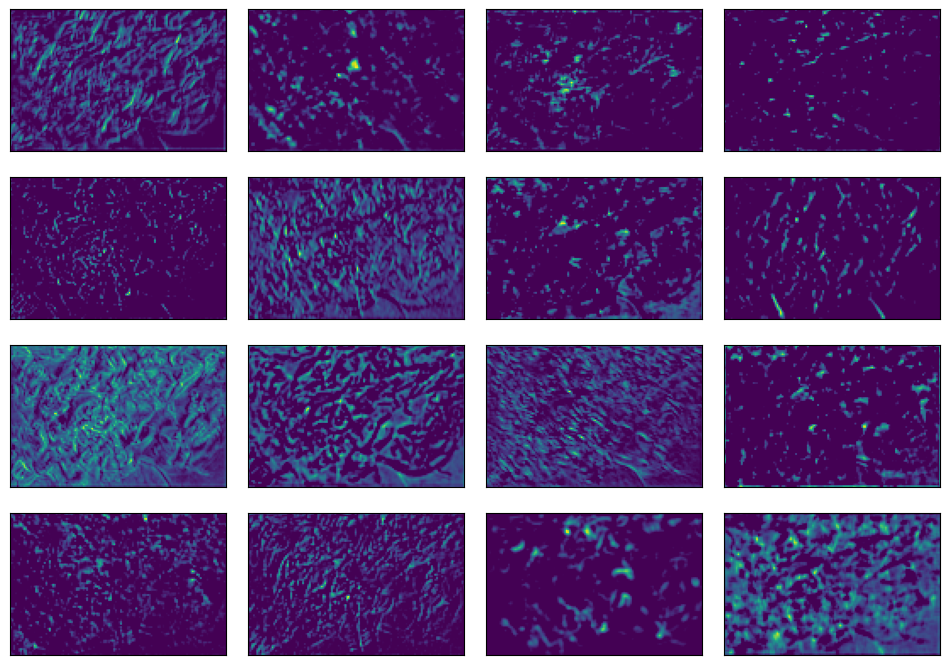


Sample feature map of block4_conv1 of shape (1, 42, 64, 512)



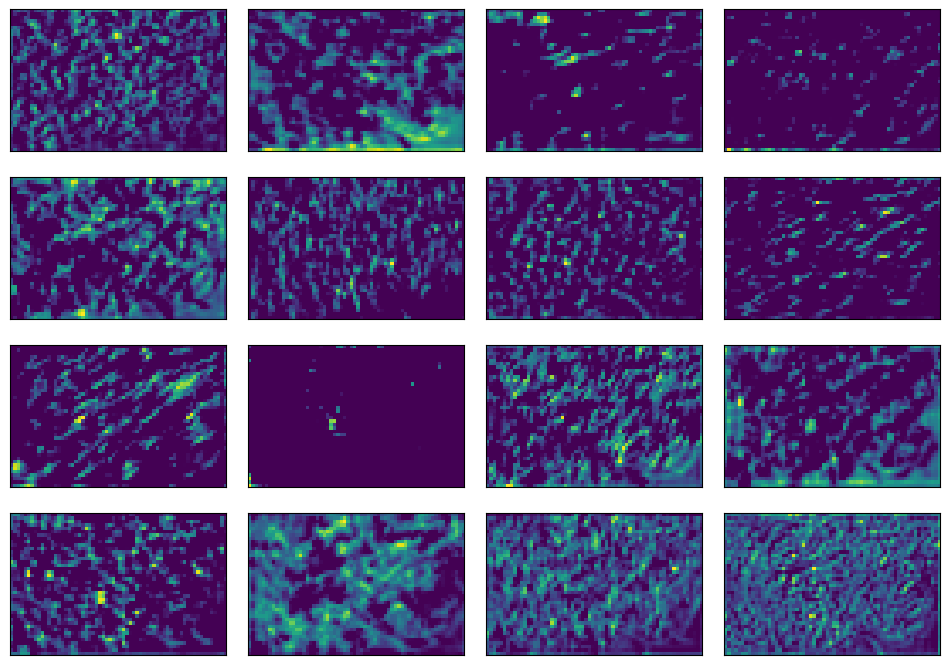


Sample feature map of block5_conv1 of shape (1, 21, 32, 512)



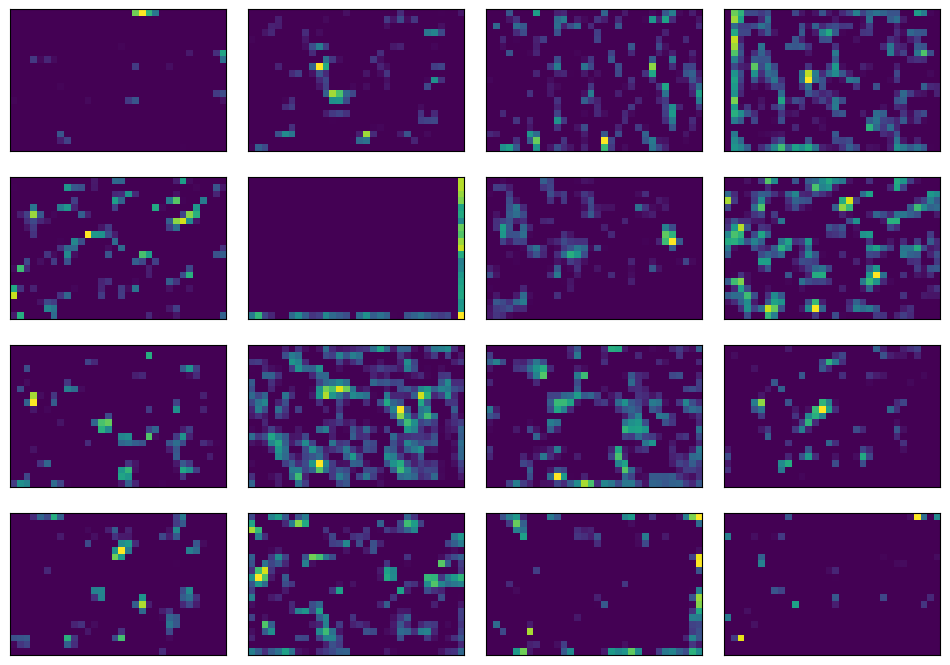

In [23]:
if feature_maps:
  display_feature_maps(content_layers+style_layers, square = 4)

In [ ]:
losses, images = train_model(style_image, content_image, style_layers, content_layers, opt)

if create_gif:
  gif(images, content_path, gif_fps)

if plot_loss:
  print('Total Variation Loss:')
  print()
  plt.figure(figsize=(10,6))
  plt.title('Total Variation Loss')
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.plot(losses)